In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import autocorrelation_plot
from pmdarima import auto_arima
import datetime as dt
sns.set_palette('colorblind')

# Seasonal ARIMA - Elliot Linsey 210764484

This notebook contains all the processes used to create predictions using the ARIMA method. At the end it also contains information about the monthly means and variances of all crime types.  

Two datasets are loaded, one containing all the crime data from 2017 - 2019 that will be used to make the predictions and the other containing the data from 2020 - 2021 that will be compared to the predictions. 

In [2]:
df = pd.read_csv(r"D:\EOY Datasets\Full Datasets\Everything_NonCovid.csv",index_col=0)

C:\Users\ellio\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df2 = pd.read_csv(r"D:\EOY Datasets\Full Datasets\Everything_cleaned.csv",index_col=0)

In [4]:
df2.Month = pd.to_datetime(df2['Month'], format='%Y-%m')

In [5]:
#df = df.reset_index(drop=True)

In [6]:
df.head()

Crime_ID    Month  \
0  9500972e2e3c87dc23b65885dd61085ee8a39329c03792...  2017-01   
1  4c3b7072a3bfcf441b1036e67fd642cf1e42fdccf16af1...  2017-01   
2  8e6ae250f68623b82068cd3c79b64b05a559f6d9c9393c...  2017-01   
3  0f5c81322cd60d96ef8877d94eb37e98cad395d1773efc...  2017-01   
4  b46b395f390b0dc9112686c30d0939f0ded0de42877df7...  2017-01   

                      Reported_by                    Crime_type  \
0  Avon and Somerset Constabulary                Theft offences   
1  Avon and Somerset Constabulary     Criminal damage and arson   
2  Avon and Somerset Constabulary     Criminal damage and arson   
3  Avon and Somerset Constabulary  Violence and sexual offences   
4  Avon and Somerset Constabulary  Violence and sexual offences   

            Outcome_type      Region  Year  
0          Other Outcome  South West  2017  
1  No suspect identified  South West  2017  
2  No suspect identified  South West  2017  
3  No suspect identified  South West  2017  
4  No suspect identified  South West  2017

In [7]:
df['Crime_type'].value_counts()

Violence and sexual offences    4009138
Theft offences                  3592460
Criminal damage and arson       1406043
Public order offences            965265
Drug offences                    367286
Name: Crime_type, dtype: int64

In [8]:
df.Month = pd.to_datetime(df['Month'], format='%Y-%m')

Creating dataframes that count the occurrences of each crime type from every month in the datasets.

In [9]:
grouped = df.groupby(['Month','Crime_type'])['Crime_ID'].count()
grouped = grouped.reset_index()

In [52]:
grouped

Month                    Crime_type  Crime_ID
0   2017-01-01     Criminal damage and arson     40283
1   2017-01-01                 Drug offences      9726
2   2017-01-01         Public order offences     18221
3   2017-01-01                Theft offences    108601
4   2017-01-01  Violence and sexual offences     90461
..         ...                           ...       ...
175 2019-12-01     Criminal damage and arson     22338
176 2019-12-01                 Drug offences      5628
177 2019-12-01         Public order offences     12818
178 2019-12-01                Theft offences     46325
179 2019-12-01  Violence and sexual offences     52665

[180 rows x 3 columns]

In [10]:
grouped2 = df2.groupby(['Month','Crime_type'])['Crime_ID'].count()
grouped2 = grouped2.reset_index()


In [11]:
plt.rcParams['font.size'] = '16'

Plotting the results of grouped to make sure they look accurate. 

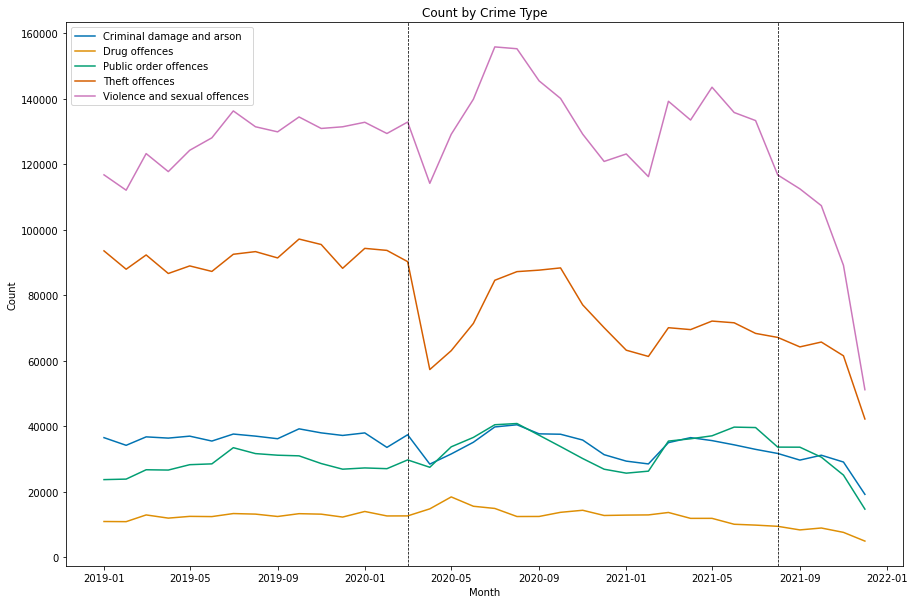

In [12]:
plt.figure(figsize=(15,10))
sns.lineplot(data=grouped2,x='Month',y='Crime_ID', hue='Crime_type')
plt.axvline(dt.datetime(2020, 3, 1),linestyle='--',color='black',linewidth=0.75)
plt.axvline(dt.datetime(2021, 8, 1),linestyle='--',color='black',linewidth=0.75)
plt.title('Count by Crime Type')
plt.legend(loc='upper left')
plt.ylabel('Count')
#plt.savefig('Count by Crime Type.png')
plt.show()

There is a big dip in values at the end of the graph, this is due to a lag in recording and is fixed later by combining the datasets together. 

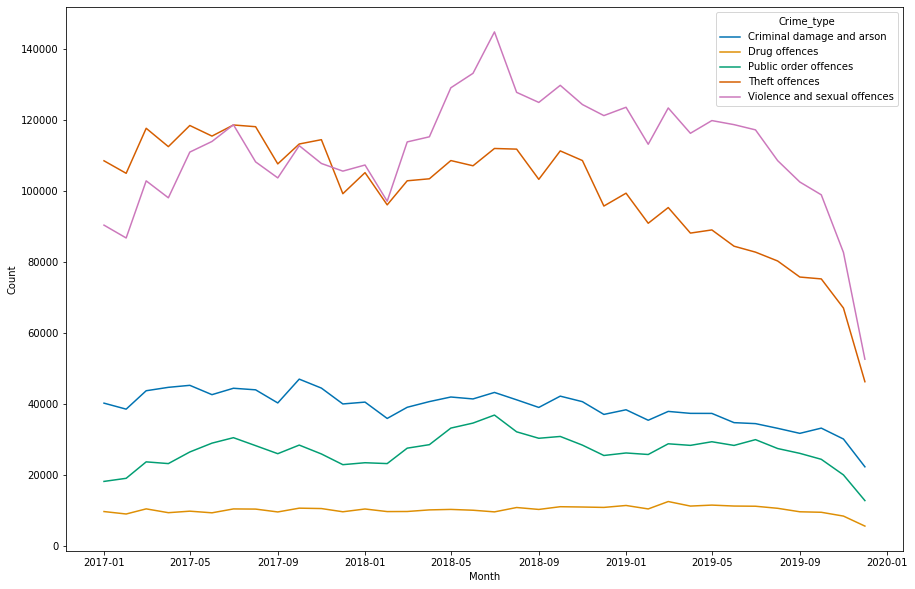

In [13]:
plt.figure(figsize=(15,10))
sns.lineplot(data=grouped,x='Month',y='Crime_ID', hue='Crime_type')
plt.ylabel('Count')
plt.show()

In [14]:
grouped

Month                    Crime_type  Crime_ID
0   2017-01-01     Criminal damage and arson     40283
1   2017-01-01                 Drug offences      9726
2   2017-01-01         Public order offences     18221
3   2017-01-01                Theft offences    108601
4   2017-01-01  Violence and sexual offences     90461
..         ...                           ...       ...
175 2019-12-01     Criminal damage and arson     22338
176 2019-12-01                 Drug offences      5628
177 2019-12-01         Public order offences     12818
178 2019-12-01                Theft offences     46325
179 2019-12-01  Violence and sexual offences     52665

[180 rows x 3 columns]

In [61]:
vio = grouped[grouped['Crime_type']=='Violence and sexual offences']
vio = vio.set_index('Month')
vio = vio['Crime_ID']
vio_cut = vio[0:12]
#vio.plot.hist()

Separating each grouped dataframe into each specific crime type. 

In [16]:
vio2 = grouped2[grouped2['Crime_type']=='Violence and sexual offences']
vio2 = vio2.set_index('Month')
vio2 = vio2['Crime_ID']

In [17]:
vio[-1] = 131435
vio[-2] = 130926
vio[-3] = 134433

In [18]:
vio[-12:] = vio2[:12]
vio[-12:]

Month
2019-01-01    116769
2019-02-01    112084
2019-03-01    123253
2019-04-01    117756
2019-05-01    124268
2019-06-01    128073
2019-07-01    136278
2019-08-01    131443
2019-09-01    129890
2019-10-01    134433
2019-11-01    130926
2019-12-01    131435
Name: Crime_ID, dtype: int64

In [53]:
#vio

### ADF Test

By running this test on timeseries data, it will return a p-value of whether it is stationary or non-stationary. A p-value above 0.05 indicates it is non-stationary, as seen with the data for violence and sexual offences below. 

Due to the upwards rising slant on all crime types, it is assumed that all are non-stationary. 

In [20]:
from statsmodels.tsa.stattools import adfuller
adfuller(vio)[1]

0.1670978086848064

In [54]:
#autocorrelation_plot(vio_cut)

In [55]:
train = vio
#train

Testing the auto_arima function on the violent and sexual crimes subtype, it outputs the order that has the lowest AIC for an ARIMA model. 

In [23]:
stepwise_fit = auto_arima(train,trace=True,suppress_warnings=True,d=1)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=731.805, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=731.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=731.350, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=731.961, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=729.945, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=728.905, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=730.041, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=730.445, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=730.028, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=728.723, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=730.410, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=732.002, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=727.149, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=730.711, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=729.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -360.574
Date:                Thu, 04 Aug 2022   AIC                            727.149
Time:                        10:43:09   BIC                            731.815
Sample:                             0   HQIC                           728.759
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0575      0.123     -0.467      0.640      -0.299       0.184
ar.L2          0.1778      0.146      1.214      0.225      -0.109       0.465
sigma2       5.38e+07   6.49e-10   8.29e+16      0.000    5.38e+07    5.38e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.44   Prob(JB):                         0.90
Heteroskedasticity (H):               0.81   Skew:                            -0.07
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+32. Standard errors may be unstable.
"""

Using the order from the auto_arima function to generate predictions for 2020 and 2021. 

In [24]:
from statsmodels.tsa.arima.model import ARIMA
train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)
model = ARIMA(train, order=(2,1,0),seasonal_order=(1,1,1,12))
model_fit = model.fit()
yhat = model_fit.predict(len(train), len(train)+23) 

print(yhat)


2020-01-01    133372.518257
2020-02-01    129119.000232
2020-03-01    140590.189352
2020-04-01    134328.227162
2020-05-01    140927.534035
2020-06-01    144785.056824
2020-07-01    152701.757805
2020-08-01    148339.623571
2020-09-01    146610.477072
2020-10-01    151653.479460
2020-11-01    148058.698235
2020-12-01    148480.974736
2021-01-01    144879.786757
2021-02-01    140256.506921
2021-03-01    151460.925841
2021-04-01    145875.826697
2021-05-01    152397.886405
2021-06-01    156208.937430
2021-07-01    164380.723554
2021-08-01    159600.200696
2021-09-01    158026.907500
2021-10-01    162627.510954
2021-11-01    159110.397999
2021-12-01    159609.406900
Freq: MS, Name: predicted_mean, dtype: float64


C:\Users\ellio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Can also generate confidence intervals, here I've used 95% and tested plotting using a fill-in ability within matplotlib.

In [26]:
forecast = model_fit.get_prediction(1)
yhat_conf_int = forecast.conf_int(alpha=0.05)
#yhat_conf_int


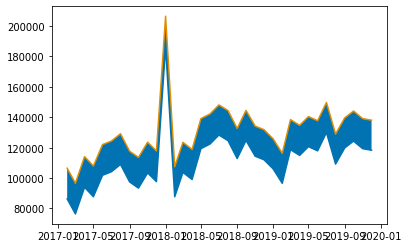

In [27]:
plt.plot(yhat_conf_int.index,yhat_conf_int['lower Crime_ID'])
plt.plot(yhat_conf_int.index,yhat_conf_int['upper Crime_ID'])
plt.fill_between(yhat_conf_int.index,yhat_conf_int['lower Crime_ID'].values, yhat_conf_int['upper Crime_ID'].values)

Below is an initial test of combining the original data with the predicted data, without the 95% confidence intervals. 

In [29]:
vio3 = pd.concat([vio,vio2[12:]])

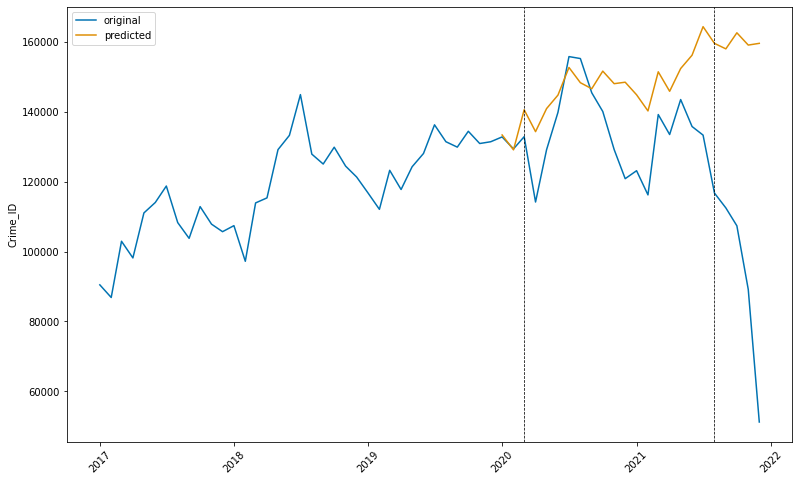

In [31]:
plt.figure(figsize=(13,8))
sns.lineplot(data=vio3,label='original')
sns.lineplot(data=yhat,label='predicted')
plt.axvline(dt.datetime(2020, 3, 1),linestyle='--',color='black',linewidth=0.75)
plt.axvline(dt.datetime(2021, 8, 1),linestyle='--',color='black',linewidth=0.75)
#sns.lineplot(data=yhat_conf_int,label='blah')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

Here I concatenate both original dataframes into one large dataframe that contains all the data from 2017 to 2021. 

In [32]:
conked = pd.concat([df,df2])
conked = conked.drop_duplicates(subset='Crime_ID')

In [56]:
grouped3 = conked.groupby(['Month'])['Crime_ID'].count()
#grouped3

I plot the total crime for all data from 2017 to 2021 to make sure the recording lag drop at the end of 2019 does not occur. 

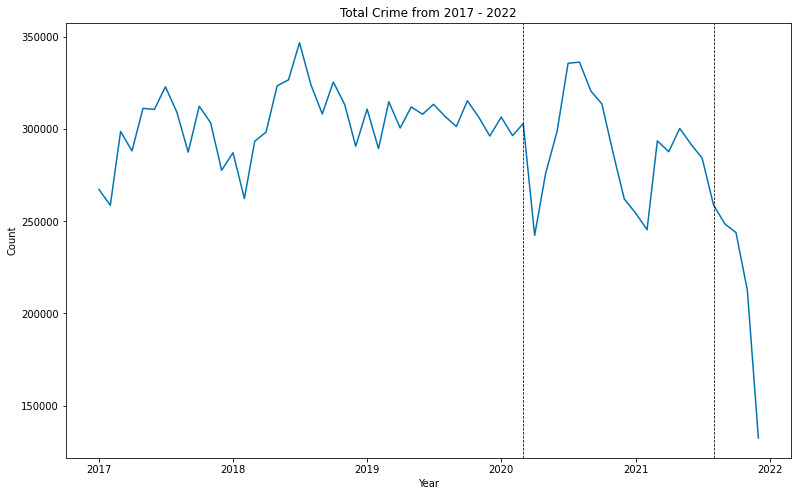

In [58]:
plt.figure(figsize=(13,8))
sns.lineplot(data=grouped3)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Total Crime from 2017 - 2022')
plt.axvline(dt.datetime(2020, 3, 1),linestyle='--',color='black',linewidth=0.75)
plt.axvline(dt.datetime(2021, 8, 1),linestyle='--',color='black',linewidth=0.75)
plt.show()

## ARIMA Functions

From here, I simply repeat all the previous steps that I performed for testing the ARIMA function, but put them into functions that are able to make predictions and graph them automatically. 

In [35]:
grouped4 = conked.groupby(['Month','Crime_type'])['Crime_ID'].count().reset_index()
grouped4

Month                    Crime_type  Crime_ID
0   2017-01-01     Criminal damage and arson     40283
1   2017-01-01                 Drug offences      9726
2   2017-01-01         Public order offences     18221
3   2017-01-01                Theft offences    108601
4   2017-01-01  Violence and sexual offences     90461
..         ...                           ...       ...
295 2021-12-01     Criminal damage and arson     19252
296 2021-12-01                 Drug offences      4987
297 2021-12-01         Public order offences     14742
298 2021-12-01                Theft offences     42251
299 2021-12-01  Violence and sexual offences     51188

[300 rows x 3 columns]

In [36]:
grouped4

Month                    Crime_type  Crime_ID
0   2017-01-01     Criminal damage and arson     40283
1   2017-01-01                 Drug offences      9726
2   2017-01-01         Public order offences     18221
3   2017-01-01                Theft offences    108601
4   2017-01-01  Violence and sexual offences     90461
..         ...                           ...       ...
295 2021-12-01     Criminal damage and arson     19252
296 2021-12-01                 Drug offences      4987
297 2021-12-01         Public order offences     14742
298 2021-12-01                Theft offences     42251
299 2021-12-01  Violence and sexual offences     51188

[300 rows x 3 columns]

In [37]:
grouped4['Crime_ID'].loc[(grouped4['Month'] == '2020-01-01')]

180     38005
181     14027
182     27314
183     94328
184    132816
Name: Crime_ID, dtype: int64

In [38]:
def predictions1(df_grouped,crime_type=None,ax=None,**kwargs):
    df_grouped = df_grouped[df_grouped.Crime_type == crime_type]
    df_grouped = df_grouped.set_index('Month').drop(columns='Crime_type').squeeze()
    train = df_grouped[:36]
    #print(train.dtypes)
#     train = train.set_index('Month')
#     train = train.drop(columns='Crime_type')
#     train = train.squeeze()
    
    #print(train)
    #train = train.squeeze()
    train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)
    model = ARIMA(train, order=(2,1,0),seasonal_order=(1,1,1,12))
    model_fit = model.fit()
    yhat = model_fit.predict(len(train), len(train)+23) 
    forecast = model_fit.get_forecast(24)
    yhat_conf_int = forecast.conf_int(alpha=0.05)
    #print(yhat)
    #print(df_grouped)
    #print(df_grouped['Crime_ID'].loc[(df_grouped['Month'] == '2020-01-01')])
    yhat.loc['2020-01-01'] = df_grouped.loc['2020-01-01']
    
    ax=ax
    ax.set_title(crime_type)
    ax.set_ylabel('Count')
    ax.set_xlabel('Year')
    #ax.axvline(dt.datetime(2020, 3, 1),linestyle='--',color='black',linewidth=0.75)
    #ax.axvline(dt.datetime(2021, 8, 1),linestyle='--',color='black',linewidth=0.75)
    sns.lineplot(data=df_grouped,label='original',ax=ax)
    sns.lineplot(data=yhat,label='predicted',ax=ax)
    ax.plot(yhat_conf_int.index,yhat_conf_int['lower Crime_ID'],linewidth=0)
    ax.plot(yhat_conf_int.index,yhat_conf_int['upper Crime_ID'],linewidth=0)
    ax.fill_between(yhat_conf_int.index,yhat_conf_int['lower Crime_ID'].values, yhat_conf_int['upper Crime_ID'].values,
                    alpha=0.2)

    #sns.lineplot(data=yhat_conf_int,label='blah')
    return ax

In [39]:
def predictions2(df_grouped,crime_type=None,ax=None,**kwargs):
    train = df_grouped[:36]
    train.index = pd.DatetimeIndex(train.index.values,
                               freq=train.index.inferred_freq)
    model = ARIMA(train, order=(2,1,0),seasonal_order=(1,1,1,12))
    model_fit = model.fit()
    yhat = model_fit.predict(len(train), len(train)+23)
    forecast = model_fit.get_forecast(24)
    #print(forecast.conf_int(alpha=0.05))
    yhat_conf_int = forecast.conf_int(alpha=0.05)
    yhat.loc['2020-01-01'] = df_grouped.loc['2020-01-01']
    ax=ax
    ax.set_title('Total Crime')
    ax.set_ylabel('Count')
    ax.set_xlabel('Year')
    #ax.axvline(dt.datetime(2020, 3, 1),linestyle='--',color='black',linewidth=0.75)
    #ax.axvline(dt.datetime(2021, 8, 1),linestyle='--',color='black',linewidth=0.75)
    sns.lineplot(data=df_grouped,label='original',ax=ax)
    sns.lineplot(data=yhat,label='predicted',ax=ax)
    ax.plot(yhat_conf_int.index,yhat_conf_int['lower Crime_ID'],linewidth=0)
    ax.plot(yhat_conf_int.index,yhat_conf_int['upper Crime_ID'],linewidth=0)
    ax.fill_between(yhat_conf_int.index,yhat_conf_int['lower Crime_ID'].values, yhat_conf_int['upper Crime_ID'].values,
                    alpha=0.2)

    #sns.lineplot(data=yhat_conf_int,label='blah')
    return ax

The errors are a result of not having 5 seasonal cycles worth of data to train on. This is discussed in the paper but does not appear to have had a major effect. 

C:\Users\ellio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\ellio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\ellio\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ellio\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters e

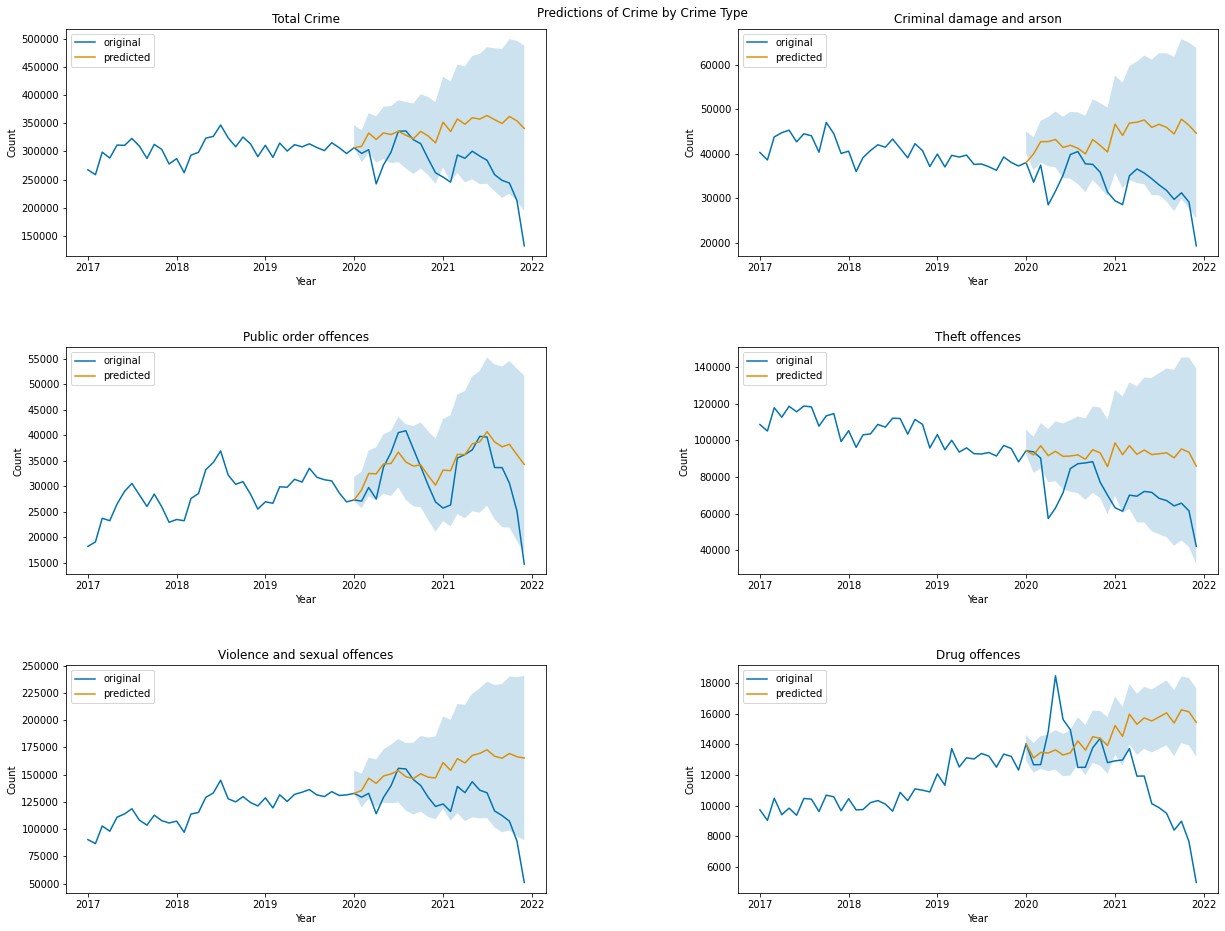

In [40]:
fig,((a1,a2),(a3,a4),(a5,a6)) = plt.subplots(3,2,figsize=(20,15))
fig.suptitle('Predictions of Crime by Crime Type',y=0.92)
predictions2(grouped3,ax=a1)
predictions1(grouped4,'Criminal damage and arson',ax=a2)
#fig2,(a3,a4) = plt.subplots(1,2,figsize=(20,5))
predictions1(grouped4,'Public order offences',ax=a3)
predictions1(grouped4,'Theft offences',ax=a4)
#fig3,(a5,a6) = plt.subplots(1,2,figsize=(20,5))
predictions1(grouped4,'Violence and sexual offences',ax=a5)
predictions1(grouped4,'Drug offences',ax=a6)

#plt.tight_layout()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
#fig.savefig('pred_crime_by_crime_type.png')
plt.show()

In [60]:
#train_whole = grouped3[:36]
#train_whole

In [59]:
# stepwise_fit2 = auto_arima(train_whole,trace=True,suppress_warnings=True,d=1)
# stepwise_fit2.summary()

## Means

This section is simply to calculate the monthly means of both covid months and non-covid months. It follows a similar process to above by grouping by month and crime type. It then generates the means and variances of these and puts them back into a dataframe. 

This is used in the Bayesian network for determining how the mean monthly crime count was affected during covid and non-covid months. 

In [43]:
means = conked.groupby(['Month','Crime_type'])['Crime_ID'].count()

In [44]:
means

Month       Crime_type                  
2017-01-01  Criminal damage and arson        40283
            Drug offences                     9726
            Public order offences            18221
            Theft offences                  108601
            Violence and sexual offences     90461
                                             ...  
2021-12-01  Criminal damage and arson        19252
            Drug offences                     4987
            Public order offences            14742
            Theft offences                   42251
            Violence and sexual offences     51188
Name: Crime_ID, Length: 300, dtype: int64

In [45]:
#means[means.Crime_type == 'Drug offences']

In [46]:
def means2(df):
    df = df.reset_index()
    cda = df[df.Crime_type == 'Criminal damage and arson']['Crime_ID'].mean()
    drugs = df[df.Crime_type == 'Drug offences']['Crime_ID'].mean()
    po = df[df.Crime_type == 'Public order offences']['Crime_ID'].mean()
    theft = df[df.Crime_type == 'Theft offences']['Crime_ID'].mean()
    vso = df[df.Crime_type == 'Violence and sexual offences']['Crime_ID'].mean()
    cda_var = np.var(df[df.Crime_type == 'Criminal damage and arson']['Crime_ID'])
    drugs_var = np.var(df[df.Crime_type == 'Drug offences']['Crime_ID'])
    po_var = np.var(df[df.Crime_type == 'Public order offences']['Crime_ID'])
    theft_var = np.var(df[df.Crime_type == 'Theft offences']['Crime_ID'])
    vso_var = np.var(df[df.Crime_type == 'Violence and sexual offences']['Crime_ID'])
    results = pd.DataFrame({'Crime_type':['Criminal damage and arson','Drug offences','Public order offences','Theft offences','Violence and sexual offences'],
                            'Means':[cda,drugs,po,theft,vso],
                           'Variance':np.round([cda_var,drugs_var,po_var,theft_var,vso_var])})

    return results

In [47]:
means2(means)

Crime_type          Means     Variance
0     Criminal damage and arson   37644.800000   25296412.0
1                 Drug offences   11492.850000    4718613.0
2         Public order offences   29763.350000   28422911.0
3                Theft offences   91633.483333  352524595.0
4  Violence and sexual offences  122046.216667  313774323.0

In [48]:
means2(grouped)

Crime_type          Means     Variance
0     Criminal damage and arson   39056.750000   24074119.0
1                 Drug offences   10202.388889    1240578.0
2         Public order offences   26812.916667   21288993.0
3                Theft offences   99790.555556  262144793.0
4  Violence and sexual offences  111364.944444  269062321.0

In [49]:
covid_months = grouped2
#covid_months

In [50]:
covid_months = covid_months[75:120]
covid_months = covid_months.drop([90,91,92,93,94])
covid_months

Month                    Crime_type  Crime_ID
75  2020-04-01     Criminal damage and arson     28481
76  2020-04-01                 Drug offences     14823
77  2020-04-01         Public order offences     27515
78  2020-04-01                Theft offences     57339
79  2020-04-01  Violence and sexual offences    114177
80  2020-05-01     Criminal damage and arson     31581
81  2020-05-01                 Drug offences     18468
82  2020-05-01         Public order offences     33761
83  2020-05-01                Theft offences     63101
84  2020-05-01  Violence and sexual offences    129148
85  2020-06-01     Criminal damage and arson     35154
86  2020-06-01                 Drug offences     15618
87  2020-06-01         Public order offences     36628
88  2020-06-01                Theft offences     71419
89  2020-06-01  Violence and sexual offences    139847
95  2020-08-01     Criminal damage and arson     40488
96  2020-08-01                 Drug offences     12487
97  2020-08-01         Public order offences     40871
98  2020-08-01                Theft offences     87227
99  2020-08-01  Violence and sexual offences    155256
100 2020-09-01     Criminal damage and arson     37722
101 2020-09-01                 Drug offences     12503
102 2020-09-01         Public order offences     37295
103 2020-09-01                Theft offences     87685
104 2020-09-01  Violence and sexual offences    145452
105 2020-10-01     Criminal damage and arson     37599
106 2020-10-01                 Drug offences     13768
107 2020-10-01         Public order offences     33835
108 2020-10-01                Theft offences     88364
109 2020-10-01  Violence and sexual offences    140091
110 2020-11-01     Criminal damage and arson     35828
111 2020-11-01                 Drug offences     14394
112 2020-11-01         Public order offences     30182
113 2020-11-01                Theft offences     77080
114 2020-11-01  Violence and sexual offences    129192
115 2020-12-01     Criminal damage and arson     31363
116 2020-12-01                 Drug offences     12803
117 2020-12-01         Public order offences     26924
118 2020-12-01                Theft offences     70119
119 2020-12-01  Violence and sexual offences    120860

In [51]:
means2(covid_months)

Crime_type       Means     Variance
0     Criminal damage and arson   34777.000   14001048.0
1                 Drug offences   14358.000    3550626.0
2         Public order offences   33376.375   21081157.0
3                Theft offences   75291.750  122849444.0
4  Violence and sexual offences  134252.875  158251458.0